In [23]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
from cade.cade import CADE
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
#functions 
def quick_plot(words, embedding):
    """
    we ignore the words we are not interested to reduce the time to compute 
    the 2D embeddings, but this is an approximation. 
    """
    
    X = embedding[words]
    pca = PCA(n_components=2)
    
    two_d_emb = pca.fit_transform(X)
    plt.scatter(two_d_emb[:, 0], two_d_emb[:, 1])

    for index, word in enumerate(words):
        plt.annotate(word, xy=(two_d_emb[index, 0], two_d_emb[index, 1]))

    plt.show()


def find_common(slice1, slice2):
    #confront the 2 slices to find the distance between every word that is present in both
    vocab1 = slice1.wv.vocab
    vocab2 = slice2.wv.vocab

    common_words = []
    for word in vocab1:
        if word in vocab2:
            common_words.append(str(word))

    distances = []
    for word in common_words:
        distance = 1 - cosine(slice1.wv[word], slice2.wv[word])
        distances.append(distance)

    data = {'word': common_words, 
            'distance':distances} 

    # Creates pandas DataFrame. 
    df = pd.DataFrame(data)
    return df

def count_common(df, slice1, slice2):
    #count how many times the common words occur in the slices
    s1_count = []
    s2_count = []
    total_count = []
    for i, row in df.iterrows():
        count1 = slice1.wv.vocab[row[0]].count
        count2 = slice2.wv.vocab[row[0]].count
        s1_count.append(count1)
        s2_count.append(count2)
        total_count.append(count1 + count2)

    df["s1_count"] = s1_count
    df["s2_count"] = s2_count
    df["total_count"] = total_count
    return df

In [3]:
base_path = 'clean-lyrics/'

first_group = range(1980,1990)
second_group = range(2016, 2020)

#maybe group in a loop 
first_songs = []
for year in first_group:
    path = base_path + str(year) + "/"
    files = os.listdir(path) 

    for file in files:
        txtReader = open(path + str(file), "r")
        txt = txtReader.read()
        first_songs.append(txt)

second_songs = []
for year in second_group:
    path = base_path + str(year) + "/"
    files = os.listdir(path) 

    for file in files:
        txtReader = open(path + str(file), "r")
        txt = txtReader.read()
        second_songs.append(txt)

In [4]:
first_blob = ' '.join(first_songs)
first_blob = first_blob.replace(",", " ")
print("lun 1 : ", len(first_blob))

second_blob = ' '.join(second_songs)
second_blob = second_blob.replace(",", " ")
print("lun 2 : ", len(second_blob))

join_blob = first_blob + second_blob
print("lun tot: ", len(join_blob))

lun 1 :  4503664
lun 2 :  5086300
lun tot:  9589964


In [5]:
with open("first.txt", "w") as output:
    output.write(str(first_blob))

with open("second.txt", "w") as output:
    output.write(str(second_blob))

with open("join.txt", "w") as output:
    output.write(str(join_blob))

In [6]:
aligner = CADE(min_count=100, workers=8, sg=0) #se sg=1 usa skipgram invece di CBOW

aligner.train_compass("join.txt", overwrite=False)
slice1 = aligner.train_slice("first.txt", save=True)
slice2 = aligner.train_slice("second.txt", save=True)

Training the compass from scratch.
Training embeddings: slice first.txt.
Initializing embeddings from compass.
Training embeddings: slice second.txt.
Initializing embeddings from compass.


In [7]:
#find the common words in the 2 slices and calculate the distance 
df = find_common(slice1, slice2)

#count how many times the common words occur in the slices
df = count_common(df, slice1, slice2)

df

word  distance  s1_count  s2_count  total_count
0        got  0.779828      7679     10382        18061
1       talk  0.791499       943      1112         2055
2        bro  0.734305       166       236          402
3     people  0.812173      1173       978         2151
4      vibes  0.595681        67        71          138
...      ...       ...       ...       ...          ...
1898     ft.  0.397541         9       111          120
1899      11  0.318915        43        70          113
1900      oi  0.623425        78        27          105
1901       –  0.676791        92       141          233
1902       ‌  0.905143        82       122          204

[1903 rows x 5 columns]

In [8]:
#most frequent common words
df.sort_values("total_count").tail(10).iloc[::-1]

word  distance  s1_count  s2_count  total_count
38   like  0.796813      9000     12815        21815
177   and  0.776385     10270     10384        20654
18   love  0.883633      9869      9610        19479
11   know  0.820670      7370     11447        18817
0     got  0.779828      7679     10382        18061
179  want  0.847676      6511      9803        16314
372  yeah  0.771417      3804      9007        12811
100    oh  0.837546      5191      7379        12570
214   get  0.832020      5536      6875        12411
89     go  0.819276      4511      6072        10583

In [9]:
#least frequent common words
df.sort_values("total_count").head(10)

word  distance  s1_count  s2_count  total_count
1717    minutes  0.646737        50        50          100
961        grip  0.441685        39        61          100
362        mike  0.486079        42        58          100
1204  shoulders  0.423785        37        63          100
1098    heading  0.404068        45        55          100
1049     singin  0.475371        51        49          100
1806     seemed  0.423717        48        52          100
1474     liquor  0.343290        46        54          100
1172    destiny  0.148677        69        31          100
1817    usually  0.253140        33        67          100

In [10]:
#worst correspondance
df.sort_values('distance').head(10)

word  distance  s1_count  s2_count  total_count
792      master  0.022685      4789        47         4836
74        naked  0.113481        74        99          173
1169      scott  0.134538        23        78          101
395   hollywood  0.144985        49        51          100
1172    destiny  0.148677        69        31          100
1332        coz  0.155779        63        60          123
1760        bae  0.185084        39        64          103
812     hearing  0.187572        44        75          119
819    emotions  0.188096        78        99          177
929    innocent  0.191835       103        44          147

In [11]:
#best correspondance
df.sort_values('distance').tail(12).iloc[::-1]

word  distance  s1_count  s2_count  total_count
1894  nante  0.948619       105        93          198
275    away  0.907810      2188      2123         4311
1902      ‌  0.905143        82       122          204
316   verse  0.898304       336       355          691
159   every  0.893897      1556      2058         3614
18     love  0.883633      9869      9610        19479
28     take  0.883038      3010      3766         6776
346     day  0.883022      2101      1916         4017
1625      “  0.876079       230       185          415
138       a  0.874383      1734      1495         3229
131   think  0.874224      1994      2786         4780
290   would  0.871364      3220      3657         6877

In [12]:
#choose the 2 lists and check if the handpicked are present in both the slices
handpicked = ["love", "smoke", "hate", "peace", "war", "pain", "rock", "shoot", "gun", "street"]
most_common = ["like", "know", "got", "want", "get", "go", "time", "never", "one", "baby"]

for el in handpicked:
    check = df[df['word'] == el]
    if len(check) != 0:
        print("ok", el)
    else:
        print("no", el)

ok love
ok smoke
ok hate
ok peace
ok war
ok pain
ok rock
ok shoot
ok gun
ok street


In [26]:
#count how many times every word chosen is present in both slices
h1 = []
h2 = []

for el1, el2 in zip(handpicked, most_common):
    h1.append(slice1.wv.vocab[el1].count) 
    h2.append(slice2.wv.vocab[el1].count)
    print(f'{el1} in slice1 appear: {slice1.wv.vocab[el1].count}')
    print(f'{el1} in slice2 appear: {slice2.wv.vocab[el1].count}')
    #print('*****************************************************')
    #print(f'{el2} in slice1 appear: {slice1.wv.vocab[el2].count}')
    #print(f'{el2} in slice2 appear: {slice2.wv.vocab[el2].count}')
    #print('*****************************************************')
    


love in slice1 appear: 9869
love in slice2 appear: 9610
smoke in slice1 appear: 236
smoke in slice2 appear: 472
hate in slice1 appear: 404
hate in slice2 appear: 625
peace in slice1 appear: 270
peace in slice2 appear: 279
war in slice1 appear: 309
war in slice2 appear: 328
pain in slice1 appear: 583
pain in slice2 appear: 706
rock in slice1 appear: 646
rock in slice2 appear: 388
shoot in slice1 appear: 142
shoot in slice2 appear: 321
gun in slice1 appear: 208
gun in slice2 appear: 248
street in slice1 appear: 410
street in slice2 appear: 325


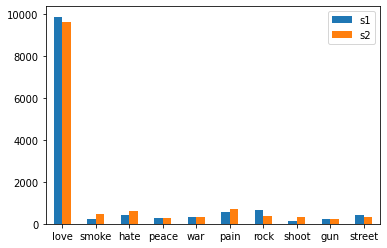

In [34]:
df_plot = pd.DataFrame({'s1': h1,'s2': h2}, index=handpicked)

ax = df_plot.plot.bar(rot=0)

In [14]:
for list_ in [handpicked, most_common]:
    for el in list_:
        dist = df[df.word==el].distance.item()
        print(el, "---", dist)
    print("***********************")

love --- 0.8836328387260437
smoke --- 0.6693958640098572
hate --- 0.7508671879768372
peace --- 0.6773001551628113
war --- 0.7156195640563965
pain --- 0.7042168378829956
rock --- 0.7685193419456482
shoot --- 0.616974413394928
gun --- 0.7186968326568604
street --- 0.6467040777206421
***********************
like --- 0.7968125939369202
know --- 0.8206697702407837
got --- 0.7798284292221069
want --- 0.8476762175559998
get --- 0.8320200443267822
go --- 0.8192760944366455
time --- 0.8471149206161499
never --- 0.8248351812362671
one --- 0.8145536184310913
baby --- 0.8202184438705444
***********************


In [15]:
for el1, el2 in zip(handpicked, most_common):
    print(el1, "\n", slice1.wv.most_similar(el1))
    print("***************************")
    print(el1, "\n",slice2.wv.most_similar(el1))
    print("***************************")
    #print(el2, "\n",slice1.wv.most_similar(el2))
    #print("***************************")
    #print(el2, "\n",slice2.wv.most_similar(el2))
    #print("***************************")

love 
 [('true', 0.5598764419555664), ('matters', 0.4939504861831665), ('guilty', 0.4772574305534363), ('baby', 0.45368465781211853), ('surely', 0.44663068652153015), ('precious', 0.43548670411109924), ('fall', 0.42447805404663086), ('heart', 0.4133562445640564), ('lovers', 0.39836585521698), ('oh', 0.39832496643066406)]
***************************
love 
 [('because', 0.43296051025390625), ('fell', 0.42210060358047485), ('true', 0.3929648995399475), ('believe', 0.3812401592731476), ('fall', 0.37815943360328674), ('someone', 0.3727523684501648), ('supposed', 0.3725547194480896), ('feel', 0.36831697821617126), ('hurting', 0.3672291934490204), ('baby', 0.36706772446632385)]
***************************
smoke 
 [('weed', 0.735649824142456), ('flows', 0.6087504029273987), ('smoking', 0.5605384111404419), ('dope', 0.5547983050346375), ('smokin', 0.5443487167358398), ('drip', 0.5008201003074646), ('pack', 0.4760000705718994), ('sippin', 0.46489617228507996), ('teeth', 0.46055689454078674), ('s

In [16]:
_list = [["hate", "love"], ["war", "peace"], ["war", "gun"],["music", "love"], 
         ["music", "hate"], ["street", "war"],["war", "love"]]
#["love", "smoke", "hate", "peace", "war", "music", "rock", "shoot", "gun", "street"]

for sub in _list:
    print(f'slice1 => {sub[0]}-{sub[1]}: ', slice1.similarity(sub[0], sub[1]))
    print(f'slice2 => {sub[0]}-{sub[1]}: ', slice2.similarity(sub[0], sub[1]))
    print("*************************************")

slice1 => hate-love:  0.21313362
slice2 => hate-love:  0.27535674
*************************************
slice1 => war-peace:  0.34219673
slice2 => war-peace:  0.21612608
*************************************
slice1 => war-gun:  0.32685873
slice2 => war-gun:  0.18801603
*************************************
slice1 => music-love:  0.084936015
slice2 => music-love:  0.018046273
*************************************
slice1 => music-hate:  0.027173549
slice2 => music-hate:  0.049690392
*************************************
slice1 => street-war:  0.13635351
slice2 => street-war:  -0.03833097
*************************************
slice1 => war-love:  -0.049543638
slice2 => war-love:  -0.022959974
*************************************


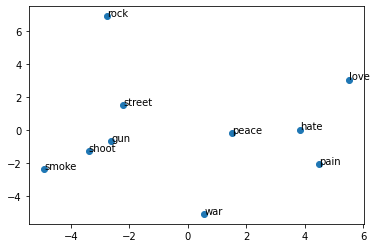

In [17]:
#plot per gli handpicked
quick_plot(handpicked, slice1)
quick_plot(handpicked, slice2)

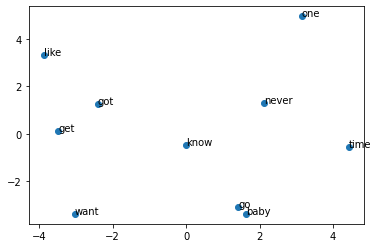

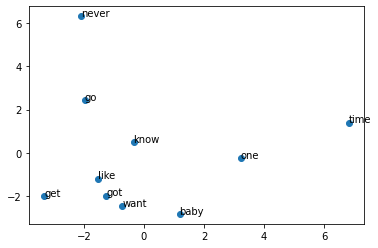

In [18]:
#plot per i most_common
quick_plot(most_common, slice1)
quick_plot(most_common, slice2)

In [19]:
#esperimento di cambio di embedding
words = ["love", "army"]
slices_to_compare = [slice1, slice2]
for word in words:
    vectors = [slice1[word], slice2[word]]
    for vector in vectors:
        for slice_to_compare in slices_to_compare:
            distances = []
            for el in slice_to_compare.wv.vocab:
                distances.append(1 - cosine(slice_to_compare[el], vector))

            data = {'word': list(slice_to_compare.wv.vocab), 
                        'distance':distances} 
            print(pd.DataFrame(data).sort_values("distance").tail(10).iloc[::-1])
            print("\n")

          word  distance
18        love  1.000000
778       true  0.559876
1732   matters  0.493951
1736    guilty  0.477257
77        baby  0.453685
1883    surely  0.446631
1546  precious  0.435487
837       fall  0.424478
238      heart  0.413356
1305    lovers  0.398366


         word  distance
60       love  0.883633
425   because  0.431128
305   someone  0.413369
1687  hurting  0.406687
54    believe  0.404851
67         oh  0.401750
761      true  0.401553
694      baby  0.388671
1596   afraid  0.366139
620   darling  0.365102


         word  distance
18       love  0.883633
778      true  0.502956
1736   guilty  0.481050
11       know  0.443713
77       baby  0.415582
837      fall  0.415371
1883   surely  0.396472
1732  matters  0.394159
1141     lose  0.389573
1844   fallin  0.378974


          word  distance
60        love  1.000000
425    because  0.432961
1139      fell  0.422101
761       true  0.392965
54     believe  0.381240
134       fall  0.378159
305    someone  